## Predict Stock Market Closing Day Prices

### Import Libraries

In [160]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import torch
import livelossplot
from ta import *
from numpy import newaxis
from sklearn.preprocessing import MinMaxScaler
from statsmodels.robust import mad
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
from keras.optimizers import Adam
from models import sparse_autoencoder
import warnings
warnings.filterwarnings("ignore")

### Add Technical Indicators

In [187]:
def moving_average(data, n):
    MA = pd.Series(data.rolling(n, min_periods=n).mean())
    return MA

In [188]:
def mtm(data, n):
    M = pd.Series(data.diff(n))
    return M

In [189]:
def rate_of_change(data, n):
    M = data.diff(n - 1)
    N = data.shift(n - 1)
    ROC = pd.Series(M / N)
    return ROC

In [190]:
# Load datas
df = pd.read_csv('article_data.csv', sep=',')

# Clean nan values
df = utils.dropna(df)

df['MACD'] = trend.macd(df['Close'])
df['CCI'] = trend.cci(df['High'], df['Low'], df['Close'])
df['ATR'] = volatility.average_true_range(df['High'], df['Low'], df['Close'])
df['BOLL'] = volatility.bollinger_mavg(df['Close'])
df['EMA20'] = trend.ema_fast(df['Close'], n_fast=20)
df['MA5'] = moving_average(df['Close'], 5)
df['MA10'] = moving_average(df['Close'], 10)
df['MTM6'] = mtm(df['Close'], 6*5*4.5)
df['MTM12'] = mtm(df['Close'], 12*5*4.5)
df['ROC'] = rate_of_change(df['Close'], 10)
df['SMI'] = momentum.stoch(df['High'], df['Low'], df['Close'])
df['WVAD'] = momentum.wr(df['High'], df['Low'], df['Close'])

print(df)
df.to_csv('article.csv')

            Date        Open        High         Low       Close    Volume  \
0     2004-08-19   50.050049   52.082081   48.028027   50.220219  44659000   
1     2004-08-20   50.555557   54.594593   50.300301   54.209209  22834300   
2     2004-08-23   55.430431   56.796795   54.579578   54.754753  18256100   
3     2004-08-24   55.675674   55.855854   51.836838   52.487488  15247300   
4     2004-08-25   52.532532   54.054054   51.991993   53.053055   9188600   
5     2004-08-26   52.527527   54.029030   52.382381   54.009010   7094800   
6     2004-08-27   54.104103   54.364365   52.897900   53.128128   6211700   
7     2004-08-30   52.692692   52.797798   51.056057   51.056057   5196700   
8     2004-08-31   51.201202   51.906906   51.131130   51.236237   4917800   
9     2004-09-01   51.401402   51.536537   49.884884   50.175175   9138200   
10    2004-09-02   49.644646   51.236237   49.519520   50.805805  15118600   
11    2004-09-03   50.525524   50.920921   49.709709   50.055054

In [191]:
for index, row in df.iterrows():
    if not row.isnull().values.any():
        firstIndex = index
        break
print(firstIndex)

270


## Normalize Data
- Using Min Max Scaler from Scikit Learn
- Scale data to range from 0 to 1

In [192]:
df_array = np.array(df.copy())
df_array = df_array[firstIndex:,1:]
close = np.array(df['Close'][firstIndex:].copy())
x_scale = MinMaxScaler()
df_array = x_scale.fit_transform(df_array)
y_scale = MinMaxScaler()
close = y_scale.fit_transform(close.reshape(-1, 1))
print(df_array)
print(close)

[[0.0965693  0.09188691 0.11094827 ... 0.57598114 0.64763797 0.64763797]
 [0.0773265  0.07822212 0.10594519 ... 0.57160059 0.61219535 0.61219535]
 [0.08672849 0.07351371 0.11004815 ... 0.53960873 0.53950082 0.53950082]
 ...
 [0.05398857 0.07142108 0.08593261 ... 0.34609257 0.35021561 0.35021561]
 [0.07423429 0.08366292 0.10016745 ... 0.34864542 0.40912995 0.40912995]
 [0.09769758 0.13097704 0.11915431 ... 0.5198331  0.72265289 0.72265289]]
[[0.09406424]
 [0.09327964]
 [0.08828325]
 [0.09569526]
 [0.10420155]
 [0.11243938]
 [0.11134509]
 [0.11958299]
 [0.11735318]
 [0.11665117]
 [0.10025808]
 [0.10773203]
 [0.12185402]
 [0.12643749]
 [0.1105812 ]
 [0.10998247]
 [0.11419426]
 [0.11468982]
 [0.1098586 ]
 [0.10046454]
 [0.08987303]
 [0.08258491]
 [0.0799009 ]
 [0.09819345]
 [0.09464232]
 [0.10583256]
 [0.09447716]
 [0.17024878]
 [0.18831423]
 [0.18472182]
 [0.20233305]
 [0.19741925]
 [0.20796946]
 [0.23681223]
 [0.25176011]
 [0.25237948]
 [0.26532467]
 [0.2745742 ]
 [0.28407143]
 [0.273479

### Denoise Data with Wavelet Transform

In [193]:
def waveletSmooth( x, wavelet="db4", level=1, DecLvl=2, title=None):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=DecLvl )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [194]:
for i in range(df_array.shape[1]):
    df_array[:,i] = waveletSmooth(df_array[:,i], level=1)[-len(df_array):]
print(df_array)

[[0.08715447 0.09818081 0.11154795 ... 0.52346764 0.62796664 0.62796664]
 [0.08607283 0.09122503 0.11198325 ... 0.55162046 0.64126155 0.64126155]
 [0.08177577 0.07733451 0.10881721 ... 0.56100195 0.6114276  0.6114276 ]
 ...
 [0.06984784 0.0687268  0.08374187 ... 0.26104019 0.19987628 0.19987628]
 [0.08374448 0.0969766  0.10422684 ... 0.43699274 0.50552003 0.50552003]
 [0.08905554 0.10606882 0.11288849 ... 0.51841816 0.64257725 0.64257725]]


### Load Data
- Split data into training and test sets as sequences
- Training set: 90%
- Test set: 10%

In [195]:
data = np.array(df_array[:,1:])

row = round(0.9 * data.shape[0])
x_train = data[:int(row), :]
y_train = close[:int(row)]
x_test = data[int(row):, :]
y_test = close[int(row):]

### Encode Features using Stacked Autoencoders

In [170]:
num_hidden_1 = 10
num_hidden_2 = 10
num_hidden_3 = 10
num_hidden_4 = 10

#Can test this value
n_epoch=20000

auto1 = sparse_autoencoder.Autoencoder(x_train.shape[1], num_hidden_1)
auto1.fit(x_train, n_epoch=n_epoch)

inputs = torch.autograd.Variable(torch.from_numpy(x_train.astype(np.float32)))

auto2 = sparse_autoencoder.Autoencoder(num_hidden_1, num_hidden_2)
auto1_out = auto1.encoder(inputs).data.numpy()
auto2.fit(auto1_out, n_epoch=n_epoch)

auto3 = sparse_autoencoder.Autoencoder(num_hidden_2, num_hidden_3)
auto1_out = torch.autograd.Variable(torch.from_numpy(auto1_out.astype(np.float32)))
auto2_out = auto2.encoder(auto1_out).data.numpy()
auto3.fit(auto2_out, n_epoch=n_epoch)

auto4 = sparse_autoencoder.Autoencoder(num_hidden_3, num_hidden_4)
auto2_out = torch.autograd.Variable(torch.from_numpy(auto2_out.astype(np.float32)))
auto3_out = auto3.encoder(auto2_out).data.numpy()
auto4.fit(auto3_out, n_epoch=n_epoch)

# Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
auto1.eval()        
auto2.eval()
auto3.eval()
auto4.eval()

x_train = torch.autograd.Variable(torch.from_numpy(x_train.astype(np.float32)))
train_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(x_train))))
train_encoded = train_encoded.data.numpy()

# Encode test data using autoencoder trained only on training data 
x_test = torch.autograd.Variable(torch.from_numpy(x_test.astype(np.float32)))
test_encoded = auto4.encoder(auto3.encoder(auto2.encoder(auto1.encoder(x_test))))
test_encoded = test_encoded.data.numpy()

### Prepare Time-Series Data
- Set Sequence Length to be 4

In [172]:
def x_shift(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    
    result = result[:, :-1]
    
    result = np.reshape(result, (1, result.shape[0], result.shape[1]))
    
    return result

def y_shift(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    
    result = result[:, -1]
    
    result = np.reshape(result, (result.shape[0]))
    
    return result

In [173]:
seq_len = 4

x_train = np.array(x_train)
x_test = np.array(x_test)

for index, column in enumerate(x_train.T):
    x_temp = x_shift(column, seq_len)
    if index == 0:
        x_placeholder = np.empty((x_train.shape[1],x_temp.shape[1],x_temp.shape[2]))
    x_placeholder[index] = x_temp
    
x_train = x_placeholder

for index, column in enumerate(x_test.T):
    x_temp = x_shift(column, seq_len)
    if index == 0:
        x_placeholder = np.empty((x_test.shape[1],x_temp.shape[1],x_temp.shape[2]))
    x_placeholder[index] = x_temp
    
x_test = x_placeholder

y_train = y_shift(y_train, seq_len)
y_test = y_shift(y_test,seq_len)

print(x_train.shape)

(18, 756, 4)


### Build Model

- Build a model with five hidden layers of LSTM
- Learning Rate = 0.05
- Uses Adam optimizer and Mean Squared Error for loss function

In [174]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(return_sequences=True, input_shape=(None, layers[0]), units=layers[1]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[2]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[3]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[4]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=False, units=layers[5]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(Dense(units=layers[6]))
    model.add(Activation("linear"))

    start = time.time()
    
    opt = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    
    print("> Compilation Time : ", time.time() - start)
    
    return model

### Test Model

- Batch Size = 60
- Number of Epochs = 5000

In [175]:
global_start_time = time.time()
epochs  = 5000
batch_size = 60

x_train = np.array(x_train).reshape(x_train.shape[1], seq_len, x_train.shape[0])
x_test = np.array(x_test).reshape(x_test.shape[1], seq_len, x_test.shape[0])

# Can test the hidden layer sizes
model = build_model([x_train.shape[2], 100, 100, 100, 100, 100, 1])

model.summary()

[[[0.09818081 0.09122503 0.07733451 ... 0.10219231 0.08174776 0.08987136]
  [0.10219231 0.10791714 0.08987136 ... 0.10233455 0.09670587 0.09464522]
  [0.10233455 0.09670587 0.09464522 ... 0.1028477  0.09940631 0.10238622]
  [0.1028477  0.09993709 0.10238622 ... 0.09245666 0.08704694 0.08086674]]

 [[0.09245666 0.08704694 0.08086674 ... 0.07710752 0.06302648 0.06409945]
  [0.07710752 0.09453446 0.06409945 ... 0.14431594 0.15093736 0.16396526]
  [0.14431594 0.15093736 0.16396526 ... 0.21826679 0.18657507 0.20337339]
  [0.21826679 0.23257616 0.20337339 ... 0.25051549 0.25511852 0.25641438]]

 [[0.25051549 0.25511852 0.25641438 ... 0.26342976 0.26177657 0.2630862 ]
  [0.26342976 0.2650364  0.2630862  ... 0.27154741 0.27675828 0.28455472]
  [0.27154741 0.27675828 0.28455472 ... 0.33451542 0.30914032 0.32661316]
  [0.33451542 0.33185706 0.32661316 ... 0.31200171 0.30466747 0.30478039]]

 ...

 [[0.15317954 0.20229892 0.28211585 ... 0.58956319 0.54218829 0.61035335]
  [0.58956319 0.54009545 0

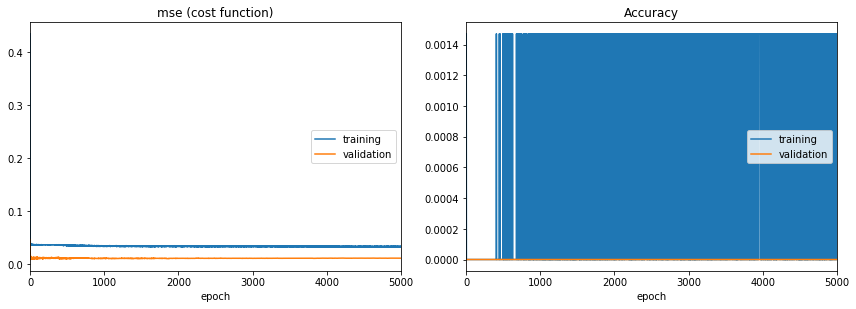

Training duration (s) :  7545.127267122269


In [176]:
plot_losses = livelossplot.PlotLossesKeras()

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[plot_losses])

model.save('article_model.h5')

model.save_weights('article_model_weights.h5')

print('Training duration (s) : ', time.time() - global_start_time)

### Plot

In [177]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

### Predictions

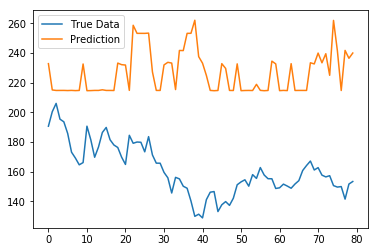

In [178]:
predicted = model.predict(x_test)

# scale back 
predicted = y_scale.inverse_transform(predicted)
y_test = y_scale.inverse_transform(y_test.reshape(-1, 1))
predicted = np.reshape(predicted, (predicted.size,))

plot_results(predicted, y_test)